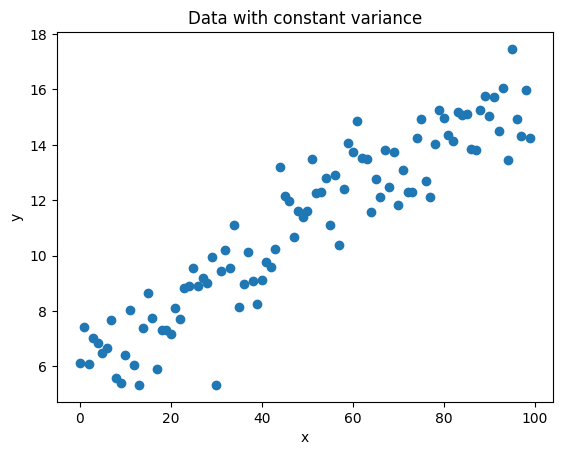

In [3]:
import numpy as np  
import matplotlib.pyplot as plt   
## Generate some data with constant variance /noise 
x = np.arange(100).reshape(100,1)
intercept_ = 6 
slope_ = 0.1 
# ## non constant error 
error_ = np.random.normal(
    size = (100,1),
    loc = 0.0,
    scale = 1) 
    
## Regression equation 
y = intercept_ + slope_ * x + error_  
plt.figure(1) 
plt.scatter(x, y) 
plt.xlabel("x") 
plt.ylabel("y") 
plt.title("Data with constant variance")
plt.show()

As seen in the plot, as we move from left to right along the x axis, we don’t see a lot of variation in the values of y. An ordinary least square regression is the ideal candidate here to model the data.

Mean squared error: 1.24
Variance score: 0.87


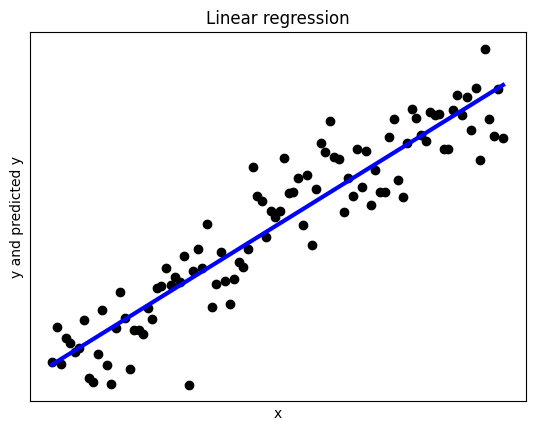

In [5]:
# Let us do a least square regression on the above dataset 
from sklearn.linear_model import LinearRegression  

model1 = LinearRegression(
    fit_intercept = True 
    # normalize = False
    ) 

model1.fit(x, y)  

y_pred1 = model1.predict(x)  
print("Mean squared error: {0:.2f}".format(np.mean((y_pred1 - y) ** 2))) 
print('Variance score: {0:.2f}'.format(model1.score(x, y)))  

# Plot the regression 
plt.figure(2) 
plt.scatter(x, y,  color='black') 
plt.plot(x, y_pred1, color='blue', linewidth=3)  
plt.xticks(()) 
plt.yticks(()) 
plt.xlabel("x") 
plt.ylabel("y and predicted y") 
plt.title("Linear regression")
plt.show()

With a variance score of 1.0, we have modeled the data perfectly. Our plot of the regression line confirms the same.

Now let us introduce some variable noise in our data. Our noise varies based on the range of our x values.

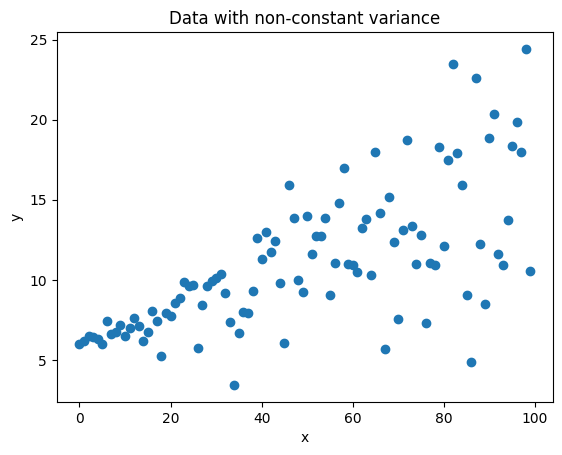

In [9]:
# Generate some data with non-constant variance 

x_ = np.arange(100).reshape(100,1) 
intercept_ = 6 
slope_ = 0.1 

# Non constant variance 
var_ = 0.1 + 0.05 * x_ 

# non constant error 
error_ = np.random.normal(size = (100,1), loc = 0.0, scale = var_) 

# Regression equation 
y_ = intercept_ + slope_ * x + error_  

plt.figure(3) 
plt.scatter(x_, y_) 
plt.xlabel("x") 
plt.ylabel("y") 
plt.title("Data with non-constant variance")
plt.show()

This phenomenon where the variability of y is unequal across the range of values of x is called as Heteroscedasticity. As seen in the plot it takes the shape of a cone. The y variable widens as the value of x increases. Let us try to fit a linear regression to this dataset.

Mean squared error: 10.29
Variance score: 0.47


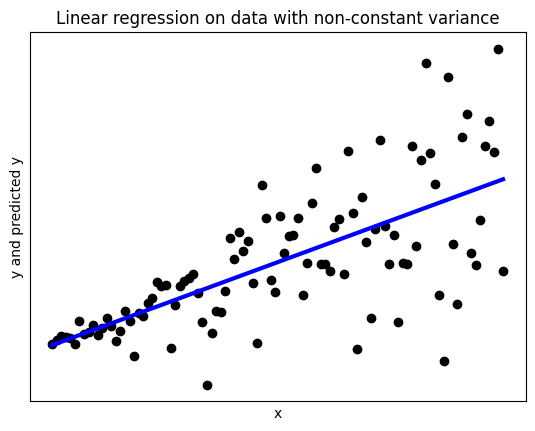

In [11]:
# Try to fit a linear regression 
model2 = LinearRegression(
    fit_intercept = True
    # normalize = False
    ) 
model2.fit(x_, y_)  

y_pred2 = model2.predict(x_)  

print("Mean squared error: {0:.2f}".format(np.mean((y_pred2 - y_) ** 2))) 
print('Variance score: {0:.2f}'.format(model1.score(x_, y_)))  

# Plot the regression 
plt.figure(4) 
plt.scatter(x_, y_,  color='black') 
plt.plot(x_, y_pred2, color='blue', linewidth=3)  
plt.xticks(()) 
plt.yticks(()) 
plt.xlabel("x") 
plt.ylabel("y and predicted y") 
plt.title("Linear regression on data with non-constant variance")
plt.show()

With variance score of 0.43 linear regression did not do a good job overall. When the x values are close to 0, linear regression is giving a good estimate of y, but we near end of x values the predicted y is far way from the actual values and hence becomes completely meaningless.

Here is where Quantile Regression comes to rescue. I have used the python package statsmodels 0.8.0 for Quantile Regression.

Let us begin with finding the regression coefficients for the conditioned median, 0.5 quantile.

In [12]:
# Quantile regression for the median, 0.5th quantile 

import pandas as pd
import statsmodels.formula.api as smf

data = pd.DataFrame(data = np.hstack([x_, y_]), columns = ["x", "y"]) 
data.head()

,x,y
0,0.0,5.978052
1,1.0,6.196645
2,2.0,6.504508
3,3.0,6.435693
4,4.0,6.330008


First we take the data into a pandas dataframe so that its easier for us to work with statsmodel interfaces. Our dataframe data has two columns, ‘x’ and ‘y’.

We then proceed to build our Quantile Regression model for the median, 0.5th quantile. The summary of our model is

In [13]:
mod = smf.quantreg('y ~ x', data) 
res = mod.fit(q=.5) 
print(res.summary())

                         QuantReg Regression Results                          
Dep. Variable:                      y   Pseudo R-squared:               0.3236
Model:                       QuantReg   Bandwidth:                       2.626
Method:                 Least Squares   Sparsity:                        6.951
Date:                Thu, 01 Jun 2023   No. Observations:                  100
Time:                        09:20:31   Df Residuals:                       98
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.9781      0.690      8.665      0.000       4.609       7.347
x              0.1011      0.012      8.397      0.000       0.077       0.125


In [22]:
res = mod.fit(q=0.5)
res.conf_int().loc['x']

0    0.077198
1    0.124982
Name: x, dtype: float64

You see that our intercept is 6.0398 and our slope or the coefficient for our x is 0.0934. These are the parameters for the 0.5th quantile of our y. Similarly we can do the models for other quantiles.

In [23]:
# Build the model for other quantiles 
quantiles = np.arange(0.1,1,0.1) 
print(quantiles)

models = [] 
params = []  
for qt in quantiles:  
    print(qt)
    res = mod.fit(q = qt )    
    models.append(res)    
    params.append([qt, res.params['Intercept'], res.params['x']] + res.conf_int().loc['x'].tolist())   

params = pd.DataFrame(data = params, columns = ['qt','intercept','x_coef','cf_lower_bound','cf_upper_bound'])  
print(params)

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
0.1
0.2
0.30000000000000004
0.4
0.5
0.6
0.7000000000000001
0.8
0.9
    qt  intercept    x_coef  cf_lower_bound  cf_upper_bound
0  0.1   5.742930  0.030916        0.007280        0.054552
1  0.2   5.978051  0.055371        0.032207        0.078536
2  0.3   6.127419  0.069228        0.045468        0.092989
3  0.4   6.061692  0.082994        0.059430        0.106558
4  0.5   5.978052  0.101090        0.077198        0.124982
5  0.6   6.067016  0.122892        0.100336        0.145449
6  0.7   5.882399  0.142967        0.119941        0.165993
7  0.8   5.987983  0.149236        0.128346        0.170127
8  0.9   5.978052  0.177165        0.149698        0.204633


In side the for loop we build models for each quantile in our list quantiles. As we build these models we us also store the model parameters in a list called params. Late we make a dataframe of the same name, so we we can view our different models.

As you see in the above output, our intercept value for the 0.1th quantile is 5.698, slope is 0.0295 and we also have the lower and the upper bound aka the intervals of our x intercept value.

Let us plot 0.1th, 0.5th and 0.9th quantile models against our original data.

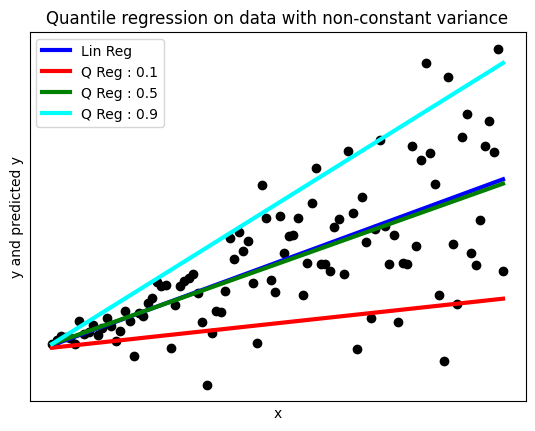

In [24]:
plt.figure(5) 
plt.scatter(x_, y_, color='black') 
plt.plot(x_, y_pred2, color='blue', linewidth=3, label='Lin Reg')

y_pred3 = models[0].params['Intercept'] + models[0].params['x'] * x_ 

plt.plot(x_, y_pred3, color='red', linewidth=3, label='Q Reg : 0.1')  

y_pred4 = models[4].params['Intercept'] + models[4].params['x'] * x_ 

plt.plot(x_, y_pred4, color='green', linewidth=3, label='Q Reg : 0.5')   

y_pred5 = models[8].params['Intercept'] + models[8].params['x'] * x_ 

plt.plot(x_, y_pred5, color='cyan', linewidth=3, label='Q Reg : 0.9')   

plt.xticks(()) 
plt.yticks(()) 
plt.xlabel("x") 
plt.ylabel("y and predicted y") 
plt.title("Quantile regression on data with non-constant variance") 
plt.legend()
plt.show()

The Ordinary Linear regression model is plotted in blue colored line. You can compare that model with other quantile models.

Another interesting way to visualize is the slope values and their upper/lower bounds for different quantile